Final finished with best results but lack the ability to generate captions

In [1]:
import torch
from torch import nn
import torchvision
from torchvision.models import resnet50
from transformers import BertModel
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
import open_clip
from transformers import BertTokenizer
from sklearn.metrics import roc_auc_score
import warnings
import gc
from transformers import BertConfig
from tqdm import tqdm
import os
import random
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from pathlib import Path
import cv2

c:\Users\Karim Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
def create_augmentations(image_path, save_dir, num_augmentations):
    img = cv2.imread(str(image_path))
    
    transforms = {
        'clahe': A.CLAHE(clip_limit=2.0, p=1.0),
        'contrast': A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
        'flip': A.HorizontalFlip(p=1.0),
        'gamma': A.RandomGamma(gamma_limit=(80, 120), p=1.0),
        'rotate': A.Rotate(limit=30, p=1.0)
    }
    
    filename = Path(image_path).stem
    
    for i in range(num_augmentations):
        selected_transforms = random.sample(list(transforms.items()), k=random.randint(1, 3))
        
        img_aug = img.copy()
        aug_name = []
        for name, transform in selected_transforms:
            img_aug = transform(image=img_aug)['image']
            aug_name.append(name)
            
        save_path = os.path.join(save_dir, f"{filename}_{'_'.join(aug_name)}.jpg")
        cv2.imwrite(save_path, img_aug)

def create_augmented_dataset(original_dir, target_size, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    original_images = list(Path(original_dir).glob('*.jpg'))
    num_originals = len(original_images)
    augs_per_image = (target_size - num_originals) // num_originals
    
    for img_path in tqdm(original_images):
        # Copy original
        img_name = img_path.name
        cv2.imwrite(os.path.join(output_dir, img_name), cv2.imread(str(img_path)))
        
        # Create augmentations
        create_augmentations(img_path, output_dir, augs_per_image)
    
    print(f"Created {target_size} images")

# Usage
create_augmented_dataset(
    original_dir=r"D:\DMID\24522883\DICOM Export",
    target_size=5000,
    output_dir=r"D:\DMID\24522883\DICOM-Augmented-Large"
)

100%|██████████| 510/510 [55:42<00:00,  6.55s/it]

Created 5000 images


In [70]:
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')


# First, let's verify report exists
import os

# Debug helper
def print_report_info(report_folder):
    print("Available reports:", os.listdir(report_folder))
    print("Sample report path:", os.path.join(report_folder))

# Modified dataset class
class AugmentedDataset(Dataset):
    def __init__(self, image_folder, report_folder, preprocess, tokenizer):
        self.image_folder = image_folder
        self.report_folder = report_folder  # Should be "D:\\DMID\\24522883\\Reports"
        self.preprocess = preprocess
        self.tokenizer = tokenizer
        
        # Debug
        print("Checking reports folder:", self.report_folder)
        print_report_info(self.report_folder)
        
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
        self.image_to_report = {}
        
        for img_name in self.image_files:
            if '_' in img_name:  # Augmented image
                num_str = img_name.split('_')[0].split('-')[1]
            else:  # Original image
                num_str = img_name.split('-')[1].split('.')[0]
            
            # Convert 5-digit to 3-digit (00071 -> 071)
            num_str = num_str[-3:].zfill(3)
            report_name = f"Img{num_str}.txt"
            self.image_to_report[img_name] = report_name
            
            # Debug
            if not os.path.exists(os.path.join(self.report_folder, report_name)):
                print(f"Warning: Missing report {report_name} for image {img_name}")
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        report_name = self.image_to_report[img_name]
        
        image_path = os.path.join(self.image_folder, img_name)
        report_path = os.path.join(self.report_folder, report_name)
        
        # Debug
        if not os.path.exists(report_path):
            print(f"Error accessing: {report_path}")
            print(f"From image: {img_name}")
            
        image = self.preprocess(Image.open(image_path))
        with open(report_path, 'r') as f:
            text = f.read().strip()
        
        inputs = self.tokenizer(text, 
                              return_tensors="pt", 
                              truncation=True, 
                              padding="max_length", 
                              max_length=128)
        
        return image, inputs['input_ids'].squeeze(0)

# Initialize with correct path
augmented_dataset = AugmentedDataset(
    image_folder="D:\\DMID\\24522883\\DICOM-Augmented-Large",
    report_folder="D:\\DMID\\24522883\\Reports\\Reports",  # Remove double Reports
    preprocess=preprocess,
    tokenizer=tokenizer
)

# Create data loaders
test_size = int(len(augmented_dataset) * 0.2)
train_size = len(augmented_dataset) - test_size
train_dataset, test_dataset = random_split(augmented_dataset, [train_size, test_size])

train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=0, 
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True
)

Checking reports folder: D:\DMID\24522883\Reports\Reports
Available reports: ['Img001.txt', 'Img002.txt', 'Img003.txt', 'Img004.txt', 'Img005.txt', 'Img006.txt', 'Img007.txt', 'Img008.txt', 'Img009.txt', 'Img010.txt', 'Img011.txt', 'Img012.txt', 'Img013.txt', 'Img014.txt', 'Img015.txt', 'Img016.txt', 'Img017.txt', 'Img018.txt', 'Img019.txt', 'Img020.txt', 'Img021.txt', 'Img022.txt', 'Img023.txt', 'Img024.txt', 'Img025.txt', 'Img026.txt', 'Img027.txt', 'Img028.txt', 'Img029.txt', 'Img030.txt', 'Img031.txt', 'Img032.txt', 'Img033.txt', 'Img034.txt', 'Img035.txt', 'Img036.txt', 'Img037.txt', 'Img038.txt', 'Img039.txt', 'Img040.txt', 'Img041.txt', 'Img042.txt', 'Img043.txt', 'Img044.txt', 'Img045.txt', 'Img046.txt', 'Img047.txt', 'Img048.txt', 'Img049.txt', 'Img050.txt', 'Img051.txt', 'Img052.txt', 'Img053.txt', 'Img054.txt', 'Img055.txt', 'Img056.txt', 'Img057.txt', 'Img058.txt', 'Img059.txt', 'Img060.txt', 'Img061.txt', 'Img062.txt', 'Img063.txt', 'Img064.txt', 'Img065.txt', 'Img066.txt'

In [13]:
for images, texts in train_loader:
    print(f"Batch images shape: {images.shape}, Batch texts shape: {texts.shape}")
    break

Batch images shape: torch.Size([32, 3, 224, 224]), Batch texts shape: torch.Size([32, 128])


In [14]:
img, txt = train_dataset[211]
print(img.shape, txt.shape)

torch.Size([3, 224, 224]) torch.Size([128])


In [15]:
print(train_dataset.__len__() + test_dataset.__len__())

4234


In [17]:
from transformers import get_linear_schedule_with_warmup
import numpy as np

class ContraLoss(nn.Module):
    def __init__(self, temp=0.1):
        super().__init__()
        self.temp = temp
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, img_features, text_features):
        # normalization
        img_features = nn.functional.normalize(img_features + 1e-8, p=2, dim=1)
        text_features = nn.functional.normalize(text_features + 1e-8, p=2, dim=1)
        
        # similarity with stability term
        sim_matrix = torch.matmul(img_features, text_features.T)
        sim_matrix = torch.clamp(sim_matrix, min=-1.0, max=1.0)
        
        # logits scalling by the temperature
        logits = sim_matrix / self.temp
        
        labels = torch.arange(logits.size(0), device=logits.device)
        
        # stable loss
        loss = (self.criterion(logits, labels) + self.criterion(logits.T, labels)) / 2
        
        # mean calculation
        pos_sim = torch.diagonal(sim_matrix).mean()
        
        if torch.isnan(loss) or torch.isnan(pos_sim):
            return None, None
            
        return loss, pos_sim

In [8]:
print(train_dataset.__len__() + test_dataset.__len__())

1521


In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [18]:
import time
import os
import gc
import torch
import wandb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch import optim
from transformers import get_linear_schedule_with_warmup

def train_model_02_wandb(model, train_data, test_data, lr=1e-4, epochs=20, device="cuda", 
                        patience=5, checkpoint_dir="checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    start_time = time.time()
    

    config_dict = {
        "learning_rate": lr,
        "epochs": epochs,
        "warmup_steps": 100,
        "batch_size": train_data.batch_size,
        "patience": patience
    }
    
    try:
        wandb.init(project="medical-clip", config=config_dict)
        
        criterion = ContraLoss(temp=0.1)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.2, betas=[0.9, 0.999])
        
        num_training_steps = len(train_data) * epochs
        num_warmup_steps = 100
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=num_warmup_steps, 
            num_training_steps=num_training_steps
        )
        
        best_val_loss = float('inf')
        best_epoch = 0
        patience_counter = 0
        max_grad_norm = 1.0
        
        history = {
            'train_loss': [], 'train_sim': [],
            'val_loss': [], 'val_sim': [],
            'lr': [], 'gpu_memory': []
        }
        
        for epoch in range(epochs):
            epoch_start = time.time()
            model.train()
            train_losses, train_sims = [], []
            
            # Training loop with progress bar
            train_pbar = tqdm(train_data, desc=f'Epoch {epoch+1}/{epochs} [Train]')
            for batch_idx, batch in enumerate(train_pbar):
                images, texts = batch
                images, texts = images.to(device), texts.to(device)
                attn_mask = (texts > 0).to(device)
                
                optimizer.zero_grad(set_to_none=True)
                
                img_features, text_features = model(images, texts, attn_mask)
                loss, sim = criterion(img_features, text_features)
                
                if loss is not None:
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                    optimizer.step()
                    scheduler.step()
                    
                    train_losses.append(loss.item())
                    train_sims.append(sim.item())
                    
 
                    train_pbar.set_postfix({
                        'loss': f'{loss.item():.4f}',
                        'sim': f'{sim.item():.4f}',
                        'lr': f'{scheduler.get_last_lr()[0]:.2e}',
                        'gpu_mem': f'{torch.cuda.memory_allocated()/1e9:.1f}GB'
                    })
                
                
                wandb.log({
                    'batch_loss': loss.item() if loss is not None else None,
                    'batch_sim': sim.item() if sim is not None else None,
                    'learning_rate': scheduler.get_last_lr()[0],
                    'gpu_memory': torch.cuda.memory_allocated()/1e9
                })
            

            model.eval()
            val_losses, val_sims = [], []
            
            val_pbar = tqdm(test_data, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            with torch.no_grad():
                for batch in val_pbar:
                    images, texts = batch
                    images, texts = images.to(device), texts.to(device)
                    attn_mask = (texts > 0).to(device)
                    
                    img_features, text_features = model(images, texts, attn_mask)
                    loss, sim = criterion(img_features, text_features)
                    
                    if loss is not None:
                        val_losses.append(loss.item())
                        val_sims.append(sim.item())
                        
                        val_pbar.set_postfix({
                            'loss': f'{loss.item():.4f}',
                            'sim': f'{sim.item():.4f}'
                        })
            
            # Calculate epoch metrics
            train_loss = np.mean(train_losses) if train_losses else float('nan')
            train_sim = np.mean(train_sims) if train_sims else float('nan')
            val_loss = np.mean(val_losses) if val_losses else float('nan')
            val_sim = np.mean(val_sims) if val_sims else float('nan')
            epoch_time = time.time() - epoch_start
            
            # Update history
            history['train_loss'].append(train_loss)
            history['train_sim'].append(train_sim)
            history['val_loss'].append(val_loss)
            history['val_sim'].append(val_sim)
            history['lr'].append(scheduler.get_last_lr()[0])
            history['gpu_memory'].append(torch.cuda.memory_allocated()/1e9)
            
            # Log epoch metrics
            wandb.log({
                'epoch': epoch,
                'train_loss': train_loss,
                'train_sim': train_sim,
                'val_loss': val_loss,
                'val_sim': val_sim,
                'epoch_time': epoch_time
            })
            
            print(f"\nEpoch {epoch+1}/{epochs} - Time: {epoch_time:.2f}s")
            print(f"Train Loss: {train_loss:.4f}, Sim: {train_sim:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Sim: {val_sim:.4f}")
            print(f"Learning Rate: {scheduler.get_last_lr()[0]:.4e}")
            print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.1f}GB")
            
        # Modified checkpoint saving
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch
                patience_counter = 0
            
                checkpoint_path = os.path.join(checkpoint_dir, "best_model_v02.pt")
                torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'train_loss': train_loss,
                'val_sim': val_sim,
                'train_sim': train_sim,
                'history': history,
                'config': config_dict  # Use config_dict instead of wandb.config
            }, checkpoint_path)
            print(f"Saved best model checkpoint (Val Loss: {val_loss:.4f})")

                
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs")
                break
                

            torch.cuda.empty_cache()
            gc.collect()
            

    except KeyboardInterrupt:
            print("\nTraining interrupted by user. Saving checkpoint...")
            interrupt_path = os.path.join(checkpoint_dir, "interrupted_model_v02.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'history': history,
                'config': config_dict  # Use config_dict here too
            }, interrupt_path)
            print(f"Saved interrupted model to {interrupt_path}")
    except Exception as e:
        print(f"Error during training: {str(e)}")
        raise e
        
    finally:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train')
        plt.plot(history['val_loss'], label='Val')
        plt.title('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history['train_sim'], label='Train')
        plt.plot(history['val_sim'], label='Val')
        plt.title('Similarity')
        plt.legend()
        
        plt.tight_layout()
        wandb.log({"learning_curves": wandb.Image(plt)})
        plt.close()
        
        wandb.finish()
        torch.cuda.empty_cache()
        
        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time/60:.2f} minutes")
        print(f"Best validation loss: {best_val_loss:.4f} (Epoch {best_epoch+1})")
        print(f"Model checkpoints saved in {checkpoint_dir}/")
        
    return history, best_val_loss

In [ ]:
# class CLIPv02(nn.Module):
#     def __init__(self, embed_dim):
#         super().__init__()
#         # Image encoder
#         self.image_encoder = resnet50(pretrained=True)  # Use pretrained weights
#         self.image_encoder.fc = nn.Sequential(
#             nn.Linear(self.image_encoder.fc.in_features, embed_dim*2),
#             nn.ReLU(),
#             nn.Linear(embed_dim*2, embed_dim),
#             nn.LayerNorm(embed_dim),
#             nn.Dropout(p=0.2)
#         )
        
#         # Text encoder
#         bert_config = BertConfig.from_pretrained("bert-base-uncased")
#         bert_config.layer_norm_params_type = "default"
#         self.text_encoder = BertModel.from_pretrained(
#             "bert-base-uncased",
#             config=bert_config
#         )
        
#         # Projection heads
#         self.text_proj = nn.Sequential(
#             nn.Linear(self.text_encoder.config.hidden_size, embed_dim*2),
#             nn.ReLU(),
#             nn.Linear(embed_dim*2, embed_dim),
#             nn.LayerNorm(embed_dim),
#             nn.Dropout(p=0.2)
#         )

#     def forward(self, image, input_ids, attn_mask):
#         # Image features
#         img_features = self.image_encoder(image)
#         img_features = img_features / img_features.norm(dim=-1, keepdim=True)

#         # Text features 
#         text_features = self.text_encoder(input_ids, attn_mask).pooler_output
#         text_features = self.text_proj(text_features)
#         text_features = text_features / text_features.norm(dim=-1, keepdim=True)

#         return img_features, text_features

### Model Architecture

In [2]:
import torch
import torch.nn as nn
from transformers import BertModel, BertConfig
from torchvision.models import resnet50

class CLIPv02(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        # Image encoder
        self.image_encoder = resnet50(pretrained=True)
        self.image_proj = nn.Sequential(
            nn.Linear(self.image_encoder.fc.in_features, embed_dim*2),
            nn.ReLU(),
            nn.Linear(embed_dim*2, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.Dropout(p=0.1)
        )
        self.image_encoder.fc = nn.Identity()  # cancel out ResNet's original FC layer

        # Text encoder
        bert_config = BertConfig.from_pretrained("bert-base-uncased")
        self.text_encoder = BertModel.from_pretrained(
            "bert-base-uncased", 
            config=bert_config
        )
        self.text_proj = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size, embed_dim*2),
            nn.ReLU(),
            nn.Linear(embed_dim*2, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.Dropout(p=0.1)
        )
        
        #TODO `Encode_Image` and `Decode_Image`

    def forward(self, image, input_ids, attn_mask):
        # Image features
        img_features = self.image_encoder(image)  
        img_features = self.image_proj(img_features)  # Project to embedding space
        img_features = img_features / img_features.norm(dim=-1, keepdim=True) 

        # Text features
        text_features = self.text_encoder(input_ids, attention_mask=attn_mask).last_hidden_state
        text_features = text_features.mean(dim=1)  # Pool features
        text_features = self.text_proj(text_features)  # Project to embedding space
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)  

        return img_features, text_features


In [20]:
model02 = CLIPv02(1024).to(device)
train_model_02_wandb(model02, train_loader, test_loader, lr=5e-5, epochs=20, device=device)

Epoch 1/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 1/20 - Time: 4565.27s
Train Loss: 3.3980, Sim: 0.0062
Val Loss: 3.1977, Sim: 0.1605
Learning Rate: 4.9851e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 3.1977)


Epoch 2/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 2/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 2/20 - Time: 4635.72s
Train Loss: 2.6777, Sim: 0.2940
Val Loss: 2.4283, Sim: 0.3476
Learning Rate: 4.7228e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 2.4283)


Epoch 3/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 3/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 3/20 - Time: 8150.39s
Train Loss: 1.5974, Sim: 0.4438
Val Loss: 1.4510, Sim: 0.5159
Learning Rate: 4.4604e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 1.4510)


Epoch 4/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 4/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 4/20 - Time: 5949.19s
Train Loss: 0.8892, Sim: 0.5612
Val Loss: 1.1000, Sim: 0.5887
Learning Rate: 4.1980e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 1.1000)


Epoch 5/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 5/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 5/20 - Time: 7325.75s
Train Loss: 0.5441, Sim: 0.6418
Val Loss: 0.8013, Sim: 0.6614
Learning Rate: 3.9356e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.8013)


Epoch 6/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 6/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 6/20 - Time: 4583.94s
Train Loss: 0.3969, Sim: 0.6856
Val Loss: 0.6060, Sim: 0.7244
Learning Rate: 3.6733e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.6060)


Epoch 7/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 7/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 7/20 - Time: 4631.60s
Train Loss: 0.3143, Sim: 0.7133
Val Loss: 0.5976, Sim: 0.7184
Learning Rate: 3.4109e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.5976)


Epoch 8/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 8/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 8/20 - Time: 3465.41s
Train Loss: 0.2606, Sim: 0.7361
Val Loss: 0.4788, Sim: 0.7532
Learning Rate: 3.1485e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.4788)


Epoch 9/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 9/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 9/20 - Time: 3783.34s
Train Loss: 0.2321, Sim: 0.7526
Val Loss: 0.4194, Sim: 0.7753
Learning Rate: 2.8861e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.4194)


Epoch 10/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 10/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 10/20 - Time: 3354.73s
Train Loss: 0.1955, Sim: 0.7642
Val Loss: 0.3796, Sim: 0.7912
Learning Rate: 2.6238e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.3796)


Epoch 11/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 11/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 11/20 - Time: 3170.86s
Train Loss: 0.1811, Sim: 0.7747
Val Loss: 0.3346, Sim: 0.8037
Learning Rate: 2.3614e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.3346)


Epoch 12/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 12/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 12/20 - Time: 3750.16s
Train Loss: 0.1688, Sim: 0.7847
Val Loss: 0.3410, Sim: 0.8077
Learning Rate: 2.0990e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.3410)


Epoch 13/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 13/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 13/20 - Time: 4981.97s
Train Loss: 0.1628, Sim: 0.7899
Val Loss: 0.2951, Sim: 0.8245
Learning Rate: 1.8366e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.2951)


Epoch 14/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 14/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 14/20 - Time: 4341.03s
Train Loss: 0.1594, Sim: 0.7971
Val Loss: 0.2934, Sim: 0.8259
Learning Rate: 1.5743e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.2934)


Epoch 15/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 15/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 15/20 - Time: 5355.28s
Train Loss: 0.1537, Sim: 0.8048
Val Loss: 0.2749, Sim: 0.8333
Learning Rate: 1.3119e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.2749)


Epoch 16/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 16/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 16/20 - Time: 11032.35s
Train Loss: 0.1288, Sim: 0.8109
Val Loss: 0.2656, Sim: 0.8416
Learning Rate: 1.0495e-05
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.2656)


Epoch 17/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 17/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 17/20 - Time: 5167.68s
Train Loss: 0.1292, Sim: 0.8166
Val Loss: 0.2555, Sim: 0.8460
Learning Rate: 7.8713e-06
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.2555)


Epoch 18/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 18/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 18/20 - Time: 9792.27s
Train Loss: 0.1362, Sim: 0.8218
Val Loss: 0.2495, Sim: 0.8509
Learning Rate: 5.2475e-06
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.2495)


Epoch 19/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 19/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 19/20 - Time: 9545.79s
Train Loss: 0.1307, Sim: 0.8232
Val Loss: 0.2438, Sim: 0.8531
Learning Rate: 2.6238e-06
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.2438)


Epoch 20/20 [Train]:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch 20/20 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]


Epoch 20/20 - Time: 3465.52s
Train Loss: 0.1343, Sim: 0.8278
Val Loss: 0.2432, Sim: 0.8552
Learning Rate: 0.0000e+00
GPU Memory: 3.5GB
Saved best model checkpoint (Val Loss: 0.2432)


batch_loss,█▇▇▆▆▅▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_sim,▁▁▁▁▂▅▅▆▆▇▇▇▇▇████▇█████████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time,▂▂▅▃▅▂▂▁▂▁▁▂▃▂▃█▃▇▇▁
gpu_memory,▃▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆████▇▇▇▇▇▆▆▆▆▆▄▄▁▂▂▁▂▂▂▂
learning_rate,▇██▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
train_loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_sim,▁▃▅▆▆▇▇▇▇▇██████████
val_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_sim,▁▃▅▅▆▇▇▇▇▇▇█████████
batch_loss,0.15847



Training completed in 1856.64 minutes
Best validation loss: 0.2432 (Epoch 20)
Model checkpoints saved in checkpoints/


({'train_loss': [3.398010105456946,
   2.677684156399853,
   1.5973658662921977,
   0.8891989425668176,
   0.544074851105798,
   0.39690371687119863,
   0.3143194614435142,
   0.2605795476515338,
   0.23213184653025754,
   0.19546840543735702,
   0.1810544211909456,
   0.16880460417355006,
   0.16276559985752376,
   0.15936315548166913,
   0.1536517023759068,
   0.1287929427651864,
   0.12916961075070332,
   0.13618441885512955,
   0.130703956995792,
   0.13429906836025557],
  'train_sim': [0.006160708423264606,
   0.2939739301800728,
   0.44376003967141203,
   0.5612196506194349,
   0.6418011115407044,
   0.685576152689052,
   0.7133260852885697,
   0.736105610177202,
   0.7526106052803543,
   0.7642123142503342,
   0.7746967116616806,
   0.7846894927744595,
   0.7899009720334467,
   0.7970875422909575,
   0.8047668860768372,
   0.8108985665834175,
   0.8166289391382685,
   0.8218022202545742,
   0.8231990669133529,
   0.82776274377445],
  'val_loss': [3.197738629800302,
   2.42827250

In [21]:

save_dir = "models"
os.makedirs(save_dir, exist_ok=True)


torch.save({
    'model_state_dict': model02.state_dict(),
    'model_config': {
        'embed_dim': 1024,
    }
}, os.path.join(save_dir, 'clip_v02_final-AugL-Drop-03.pth'))

### Inference

In [69]:
import torch
from transformers import BertTokenizer
from tqdm import tqdm

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def extract_text_embeddings(model, captions, batch_size=32):
    model.eval()
    all_embeddings = []
    
    # Process in batches
    for i in tqdm(range(0, len(captions), batch_size)):
        batch_captions = captions[i:i + batch_size]
        
        # Tokenize batch
        tokens = tokenizer(
            batch_captions,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(model.device)
        
        # Extract embeddings
        with torch.no_grad():
            _, text_features = model(
                None,
                tokens['input_ids'],
                tokens['attention_mask']
            )
            text_features = F.normalize(text_features, dim=-1)
            all_embeddings.append(text_features.cpu())
    
    # Concatenate all embeddings
    text_embeddings = torch.cat(all_embeddings, dim=0)
    
    # Save embeddings for reuse
    torch.save(text_embeddings, 'text_embeddings.pt')
    
    return text_embeddings

# Extract embeddings
text_embeddings = extract_text_embeddings(
    clip_inference.model,
    train_dataset.captions
)

print(f"Extracted embeddings shape: {text_embeddings.shape}")

NameError: name 'train_dataset' is not defined

In [72]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

class CLIPInference:
    def __init__(self, model_path, device=None):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') if device is None else device
        self.model = CLIPv02(embed_dim=1024)
        self.model.load_state_dict(torch.load(model_path)['model_state_dict'])
        self.model.eval()
        self.model.to(self.device)

    def extract_image_embeddings(self, image_tensor):
        with torch.no_grad():
            image_features, _ = self.model(image_tensor, None, None)
            return F.normalize(image_features, dim=-1)

    def extract_text_embeddings(self, text_data, tokenizer):
        text_embeddings = []
        with torch.no_grad():
            for text in tqdm(text_data):
                tokens = tokenizer(
                    text, 
                    padding=True,
                    truncation=True,
                    max_length=128,
                    return_tensors="pt"
                ).to(self.device)
                
                _, text_features = self.model(
                    None,
                    tokens['input_ids'],
                    tokens['attention_mask']
                )
                text_embeddings.append(F.normalize(text_features, dim=-1).cpu())
        return torch.cat(text_embeddings)

    def find_nearest_captions(self, image_embedding, text_embeddings, captions, k=5):
        # Calculate similarities
        similarities = cosine_similarity(
            image_embedding.cpu().numpy(),
            text_embeddings.cpu().numpy()
        )[0]
        
        # Get top k indices
        top_k_idx = np.argsort(similarities)[-k:][::-1]
        
        return [(captions[idx], similarities[idx]) for idx in top_k_idx]

# Usage
# First get captions from dataset
train_captions = []
for idx in range(len(train_dataset)):
    _, caption = train_dataset[idx]  # Assuming dataset returns (image, caption) pairs
    train_captions.append(caption)

# Now extract embeddings
clip_inference = CLIPInference("models/clip_v02_final-AugL-Drop-03.pth")

# Create text embeddings database with proper captions list
text_embeddings = clip_inference.extract_text_embeddings(
    train_captions,  # Using extracted captions list
    tokenizer
)

# Test on single image
image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"
image = Image.open(image_path).convert('RGB')
image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)

image_embedding = clip_inference.extract_image_embeddings(image_tensor)
matches = clip_inference.find_nearest_captions(
    image_embedding,
    text_embeddings,
    train_captions  # Using same captions list
)

print("\nNearest captions:")
for caption, similarity in matches:
    print(f"Similarity: {similarity:.3f} | Caption: {caption}")

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [74]:
# First debug what we're getting from dataset
print("First few captions:")
for i, (_, caption) in enumerate(train_dataset):
    if i < 5:  # Print first 5 captions
        print(f"Type: {type(caption)}, Content: {caption}")

# Modified CLIPInference class with fixed text embedding extraction
class CLIPInference:
    def __init__(self, model_path, device=None):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') if device is None else device
        self.model = CLIPv02(embed_dim=1024)
        self.model.load_state_dict(torch.load(model_path)['model_state_dict'])
        self.model.eval()
        self.model.to(self.device)

    def extract_text_embeddings(self, text_data, tokenizer, batch_size=32):
        # Convert all items to strings if they aren't already
        text_data = [str(text) for text in text_data]
        text_embeddings = []
        
        # Process in batches
        for i in tqdm(range(0, len(text_data), batch_size)):
            batch_texts = text_data[i:i + batch_size]
            
            # Tokenize batch
            tokens = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors="pt"
            ).to(self.device)
            
            with torch.no_grad():
                _, text_features = self.model(
                    None,
                    tokens['input_ids'],
                    tokens['attention_mask']
                )
                text_embeddings.append(F.normalize(text_features, dim=-1).cpu())
        
        return torch.cat(text_embeddings)

# Usage
clip_inference = CLIPInference("models/clip_v02_final-AugL-Drop-03.pth")

# Convert captions to strings explicitly
train_captions = [str(caption) for _, caption in train_dataset]

# Create text embeddings database
text_embeddings = clip_inference.extract_text_embeddings(
    train_captions,
    tokenizer
)

# Test on single image
image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"
image = Image.open(image_path).convert('RGB')
image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)

image_embedding = clip_inference.extract_image_embeddings(image_tensor)
matches = clip_inference.find_nearest_captions(
    image_embedding,
    text_embeddings,
    train_captions
)

print("\nNearest captions:")
for caption, similarity in matches:
    print(f"Similarity: {similarity:.3f} | Caption: {caption}")

First few captions:
Type: <class 'torch.Tensor'>, Content: tensor([  101,  7209,  5239,   131,  1180,  1136,  1129,  6454,  1852,  9505,
          131,   170,  3321,  1218,  3393, 25338, 23601,  1906,  2991, 11769,
        19905,  1562,  5336,  1103,  2072,  7209,  5401,  1344, 10108, 12477,
         2646, 15454,  8241,  1988,   113, 16516,  9871,  1116,   125,  1665,
          114,   119,  1185, 22832, 17599,  7867,  6617, 11531,  1562,   119,
        16516,  9871,  1116,   131,   125,  1665,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
     

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

TypeError: conv2d() received an invalid combination of arguments - got (NoneType, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


In [75]:
class CLIPInference:
    def __init__(self, model_path, device=None):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') if device is None else device
        self.model = CLIPv02(embed_dim=1024)
        self.model.load_state_dict(torch.load(model_path)['model_state_dict'])
        self.model.eval()
        self.model.to(self.device)
        
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def extract_text_embeddings(self, text_data, tokenizer, batch_size=32):
        text_data = [str(text) for text in text_data]
        text_embeddings = []
        
        for i in tqdm(range(0, len(text_data), batch_size)):
            batch_texts = text_data[i:i + batch_size]
            
            tokens = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors="pt"
            ).to(self.device)

            # Create dummy image tensor of correct shape
            dummy_image = torch.zeros(len(batch_texts), 3, 224, 224).to(self.device)
            
            with torch.no_grad():
                _, text_features = self.model(
                    dummy_image,
                    tokens['input_ids'],
                    tokens['attention_mask']
                )
                text_embeddings.append(F.normalize(text_features, dim=-1).cpu())
        
        return torch.cat(text_embeddings)

    def extract_image_embeddings(self, image_tensor):
        with torch.no_grad():
            # Create dummy text inputs
            dummy_tokens = {
                'input_ids': torch.zeros(1, 1).long().to(self.device),
                'attention_mask': torch.ones(1, 1).to(self.device)
            }
            
            image_features, _ = self.model(
                image_tensor,
                dummy_tokens['input_ids'],
                dummy_tokens['attention_mask']
            )
            return F.normalize(image_features, dim=-1)

    def find_nearest_captions(self, image_embedding, text_embeddings, captions, k=5):
        similarities = torch.matmul(image_embedding, text_embeddings.t())[0]
        top_k_idx = torch.argsort(similarities, descending=True)[:k]
        return [(captions[idx], similarities[idx].item()) for idx in top_k_idx]

# Usage
clip_inference = CLIPInference("models/clip_v02_final-AugL-Drop-03.pth")
train_captions = [str(caption) for _, caption in train_dataset]

text_embeddings = clip_inference.extract_text_embeddings(
    train_captions,
    tokenizer
)

image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"
image = Image.open(image_path).convert('RGB')
image_tensor = clip_inference.preprocess(image).unsqueeze(0).to(device)

image_embedding = clip_inference.extract_image_embeddings(image_tensor)
matches = clip_inference.find_nearest_captions(
    image_embedding,
    text_embeddings,
    train_captions
)

print("\nNearest captions:")
for caption, similarity in matches:
    print(f"Similarity: {similarity:.3f} | Caption: {caption}")

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [76]:
class CLIPInference:
    def __init__(self, model_path, device=None):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') if device is None else device
        self.model = CLIPv02(embed_dim=1024)
        self.model.load_state_dict(torch.load(model_path)['model_state_dict'])
        self.model.eval()
        self.model.to(self.device)
        
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def extract_text_embeddings(self, text_data, tokenizer, batch_size=32):
        text_data = [str(text) for text in text_data]
        text_embeddings = []
        
        for i in tqdm(range(0, len(text_data), batch_size)):
            batch_texts = text_data[i:i + batch_size]
            
            tokens = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors="pt"
            ).to(self.device)

            dummy_image = torch.zeros(len(batch_texts), 3, 224, 224).to(self.device)
            
            with torch.no_grad():
                _, text_features = self.model(
                    dummy_image,
                    tokens['input_ids'],
                    tokens['attention_mask']
                )
                text_embeddings.append(text_features.cpu())
        
        return torch.cat(text_embeddings, dim=0)

    def extract_image_embeddings(self, image_tensor):
        with torch.no_grad():
            dummy_tokens = {
                'input_ids': torch.zeros(1, 1).long().to(self.device),
                'attention_mask': torch.ones(1, 1).to(self.device)
            }
            
            image_features, _ = self.model(
                image_tensor,
                dummy_tokens['input_ids'],
                dummy_tokens['attention_mask']
            )
            return image_features

    def find_nearest_captions(self, image_embedding, text_embeddings, captions, k=5):
        # Move tensors to same device
        image_embedding = image_embedding.to(self.device)
        text_embeddings = text_embeddings.to(self.device)
        
        # Normalize embeddings
        image_embedding = F.normalize(image_embedding, dim=-1)
        text_embeddings = F.normalize(text_embeddings, dim=-1)
        
        # Calculate similarities
        similarities = torch.matmul(image_embedding, text_embeddings.t())[0]
        top_k_idx = torch.argsort(similarities, descending=True)[:k]
        
        return [(captions[idx], similarities[idx].item()) for idx in top_k_idx]

# Usage
clip_inference = CLIPInference("models/clip_v02_final-AugL-Drop-03.pth")
train_captions = [str(caption) for _, caption in train_dataset]

# Get text embeddings
text_embeddings = clip_inference.extract_text_embeddings(
    train_captions,
    tokenizer
)

# Process image
image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"
image = Image.open(image_path).convert('RGB')
image_tensor = clip_inference.preprocess(image).unsqueeze(0).to(clip_inference.device)

# Get image embedding
image_embedding = clip_inference.extract_image_embeddings(image_tensor)

# Find matches
matches = clip_inference.find_nearest_captions(
    image_embedding,
    text_embeddings,
    train_captions
)

print("\nNearest captions:")
for caption, similarity in matches:
    print(f"Similarity: {similarity:.3f} | Caption: {caption}")

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl


Nearest captions:
Similarity: 0.156 | Caption: tensor([  101,  7209,  5239,   131,  8941, 20497, 12725, 24862,  7209, 14247,
         1424,  8992,  1918,   113,   170,  1665,  1197,   118,   170,   114,
          119, 16516,  9871,  1116,   131,   126,  9505,   131,   170,  1415,
        12692,  2991, 11769, 19905,  1114,   170,   188, 20437,  8360,  7464,
         1114,   175, 13335,  1182,  1104,  4422, 17599,  7867,  6617, 11531,
         1116,  1562,  1107,  1103,  5047,   186, 18413,  6922,  1104,  1103,
         7209,  1107,  8702,  6066,  7969, 16201,  1158,  2241,  5401,   170,
        12477,  2646, 15454,  8241,  1988,   113, 16516,  9871,  1116,   126,
          114,   119, 15070,  2691,  2999,   119, 26181, 11368,   118, 26557,
        11019,  1233,  6617, 11531,  1562,   119,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,  

In [77]:
# Usage
clip_inference = CLIPInference("models/clip_v02_final-AugL-Drop-03.pth")

# Clean and format captions properly
train_captions = []
for _, caption in train_dataset:
    # Convert tensor to string if needed
    if isinstance(caption, torch.Tensor):
        caption = caption.numpy().tolist()  # Convert tensor to list
    # Convert list/array to string if needed
    if isinstance(caption, (list, np.ndarray)):
        caption = ' '.join(map(str, caption))
    train_captions.append(str(caption))

# Get text embeddings
text_embeddings = clip_inference.extract_text_embeddings(
    train_captions,
    tokenizer
)

# Process image
image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"
image = Image.open(image_path).convert('RGB')
image_tensor = clip_inference.preprocess(image).unsqueeze(0).to(clip_inference.device)

# Get image embedding
image_embedding = clip_inference.extract_image_embeddings(image_tensor)

# Find matches
matches = clip_inference.find_nearest_captions(
    image_embedding,
    text_embeddings,
    train_captions
)

print("\nNearest captions:")
for caption, similarity in matches:
    print(f"Similarity: {similarity:.3f} | Caption: {caption}")

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl


Nearest captions:
Similarity: 0.090 | Caption: 101 7209 5239 131 20497 12725 24862 1105 7648 176 1931 5552 7209 14247 1424 8992 1918 113 170 1665 1197 171 114 16516 9871 1116 131 122 9505 131 1185 22832 2991 11769 19905 2241 1105 15070 118 1185 22832 1785 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Similarity: 0.090 | Caption: 101 7209 5239 131 20497 12725 24862 1105 7648 176 1931 5552 7209 14247 1424 8992 1918 113 170 1665 1197 171 114 16516 9871 1116 131 122 9505 131 1185 22832 2991 11769 19905 2241 1105 15070 118 1185 22832 1785 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Similarity: 0.090 | Caption: 101 7209 5239 131 20497 12725 24862 1105 7648 176 1931 5552 7209 14247 1424 8992 1918 113 170 1665 1197 171 114 16516 9871 1116 

In [73]:
print("First few captions:")
for i, (_, caption) in enumerate(train_dataset):
    if i < 5:  # Print first 5 captions
        print(f"Type: {type(caption)}, Content: {caption}")

First few captions:
Type: <class 'torch.Tensor'>, Content: tensor([  101,  7209,  5239,   131,  1180,  1136,  1129,  6454,  1852,  9505,
          131,   170,  3321,  1218,  3393, 25338, 23601,  1906,  2991, 11769,
        19905,  1562,  5336,  1103,  2072,  7209,  5401,  1344, 10108, 12477,
         2646, 15454,  8241,  1988,   113, 16516,  9871,  1116,   125,  1665,
          114,   119,  1185, 22832, 17599,  7867,  6617, 11531,  1562,   119,
        16516,  9871,  1116,   131,   125,  1665,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
     

KeyboardInterrupt: 

In [41]:
import torch.nn.functional as F
class CLIPv02Inference:
    def __init__(self, model_path, device=device):
        self.device = device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = CLIPv02(embed_dim=1024)
        checkpoints = torch.load(model_path)
        self.model.load_state_dict(checkpoints['model_state_dict'])
        self.model.eval()
        self.model.to(self.device)
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    def get_similarity(self, image_path, text):
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.preprocess(image).unsqueeze(0).to(self.device)
        tokens = self.tokenizer(
            text, 
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        input_ids = tokens['input_ids'].to(self.device)
        attn_mask = tokens['attention_mask'].to(self.device)
        with torch.no_grad():
            img_features, text_features = self.model(
                image_tensor,
                input_ids,
                attn_mask
            )
            img_features = img_features / img_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            similarity = torch.matmul(img_features,text_features.T)
        return similarity.item()
    def best_match(self, image_path, text_can):
        similarities = []
        for text in text_can:
            score = self.get_similarity(image_path, text)
            similarities.append((text, score))
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities


In [52]:
class CLIPv02Inference:
    def __init__(self, model_path, device=None, temperature=0.07):
        self.temperature = temperature
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') if device is None else device
        
        # Load model
        self.model = CLIPv02(embed_dim=1024)
        checkpoints = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoints['model_state_dict'])
        self.model.eval()
        self.model.to(self.device)
        
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def get_similarity(self, image_path, text_list):
        """Calculate contrastive similarity scores between image and text list"""
        # Process image
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.preprocess(image).unsqueeze(0).to(self.device)
        
        # Process all texts as a batch
        tokens = self.tokenizer(
            text_list,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(self.device)
        
        with torch.no_grad():
            # Get features
            img_features, text_features = self.model(
                image_tensor,
                tokens['input_ids'],
                tokens['attention_mask']
            )
            
            # Normalize features
            img_features = F.normalize(img_features, dim=-1)
            text_features = F.normalize(text_features, dim=-1)
            
            # Calculate similarity matrix
            logits = torch.matmul(img_features, text_features.T) / self.temperature
            
            # Calculate contrastive probabilities
            probs = F.softmax(logits, dim=-1).squeeze()
            
            # Get individual scores using cross-entropy normalization
            scores = []
            for i, text in enumerate(text_list):
                # Calculate positive pair score
                pos_score = logits[0, i]
                
                # Calculate negative pairs score (other texts)
                neg_indices = [j for j in range(len(text_list)) if j != i]
                neg_scores = logits[0, neg_indices]
                
                # Normalized score using positive and negative pairs
                normalized_score = (pos_score / (pos_score + neg_scores.sum())).item()
                scores.append((text, normalized_score))
            
        return scores

    def find_best_matches(self, image_path, text_candidates, top_k=5):
        # Get normalized similarity scores
        similarities = self.get_similarity(image_path, text_candidates)
        
        # Sort by score
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        return similarities[:top_k]

# Usage example
def test_clip_inference():
    clip_inference = CLIPv02Inference(
        model_path="models/clip_v02_final-AugL-Drop-03.pth",
        temperature=0.07
    )
    
    image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"
    candidates = ["fibro", "fatty", "glandular", "breast parenchyma", "and",'pizza']
    
    matches = clip_inference.find_best_matches(image_path, candidates)
    print("\nContrastive matches:")
    for text, score in matches:
        print(f"Score: {score:.3f} | Text: {text}")

if __name__ == "__main__":
    test_clip_inference()

c:\Users\Karim Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Karim Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [43]:
model_path = "models/clip_v02_final-AugL-Drop-03.pth"
clip_inference = CLIPv02Inference(model_path)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import string
def read_reports(report_folder):
    reports = []
    for filename in os.listdir(report_folder):
        if filename.endswith(".txt"):
            with open(os.path.join(report_folder, filename), 'r') as file:
                reports.append(file.read())
    return reports

# Function to preprocess text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)
def extract_vocabulary(reports):
    preprocessed_reports = [preprocess_text(report) for report in reports]
    vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
    X = vectorizer.fit_transform(preprocessed_reports)
    vocabulary = vectorizer.get_feature_names_out()
    return vocabulary
report_folder = "D:\\DMID\\24522883\\Reports\\Reports" 
reports = read_reports(report_folder)
vocabulary = extract_vocabulary(reports)
print(vocabulary)

['23' '23rd' '4a' '4b' '4c' '4cno' 'abnormal' 'abnormality'
 'abovementioned' 'acr' 'acra' 'acrb' 'acrc' 'acrd' 'adenopathies'
 'adenopathy' 'adjacent' 'amorphous' 'another' 'anterior' 'appear'
 'appearance' 'appears' 'architectural' 'area' 'areolar' 'aspect'
 'aspects' 'asymetric' 'asymmetric' 'axilla' 'axillary' 'beingn' 'benign'
 'benignlooking' 'benignvascular' 'benin' 'bening' 'beninglooking'
 'biards' 'bifid' 'birads' 'birads3' 'birads4a' 'birads4b' 'birads4c'
 'birads5' 'branching' 'breast' 'breastbirads' 'brest' 'calcification'
 'calcifications' 'calcified' 'causing' 'central' 'chemoport' 'coarse'
 'commented' 'composition' 'compositions' 'correlation' 'could' 'defied'
 'defined' 'dense' 'densities' 'density' 'diffuse' 'discrete' 'distortion'
 'eggshell' 'elevate' 'encapsulated' 'enlarged' 'entire' 'entirely'
 'extending' 'fat' 'fatty' 'fibro' 'fibroadenoma' 'fibroadenomas'
 'fibrofatty' 'fibroglandular' 'findings' 'fine' 'finidngs' 'foci' 'focus'
 'fundings' 'glandular' 'half'

In [54]:
class CLIPv02Inference:
    def __init__(self, model_path, device=None, temperature=0.07):
        self.temperature = temperature
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') if device is None else device
        
        # Load model
        self.model = CLIPv02(embed_dim=1024)
        checkpoints = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoints['model_state_dict'])
        self.model.eval()
        self.model.to(self.device)
        
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def get_similarity(self, image_path, text_list):
        """Calculate contrastive similarity scores between image and text list"""
        # Process image
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.preprocess(image).unsqueeze(0).to(self.device)
        
        # Ensure text_list is a list of strings
        if isinstance(text_list, str):
            text_list = [text_list]
        
        # Process all texts as a batch
        tokens = self.tokenizer(
            text_list,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(self.device)
        
        with torch.no_grad():
            # Get features
            img_features, text_features = self.model(
                image_tensor,
                tokens['input_ids'],
                tokens['attention_mask']
            )
            
            # Normalize features
            img_features = F.normalize(img_features, dim=-1)
            text_features = F.normalize(text_features, dim=-1)
            
            # Calculate similarity matrix
            logits = torch.matmul(img_features, text_features.T) / self.temperature
            
            # Calculate contrastive probabilities
            probs = F.softmax(logits, dim=-1).squeeze()
            
            # Get individual scores using cross-entropy normalization
            scores = []
            for i, text in enumerate(text_list):
                # Calculate positive pair score
                pos_score = logits[0, i]
                
                # Calculate negative pairs score (other texts)
                neg_indices = [j for j in range(len(text_list)) if j != i]
                neg_scores = logits[0, neg_indices]
                
                # Normalized score using positive and negative pairs
                normalized_score = (pos_score / (pos_score + neg_scores.sum())).item()
                scores.append((text, normalized_score))
            
        return scores

    def find_best_matches(self, image_path, text_candidates, top_k=5):
        # Get normalized similarity scores
        similarities = self.get_similarity(image_path, text_candidates)
        
        # Sort by score
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        return similarities[:top_k]

# Usage example
def test_clip_inference():
    clip_inference = CLIPv02Inference(
        model_path="models/clip_v02_final-AugL-Drop-03.pth",
        temperature=0.07
    )
    
    image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"
    candidates = vocabulary[:100]
    
    matches = clip_inference.find_best_matches(image_path, candidates)
    print("\nContrastive matches:")
    for text, score in matches:
        print(f"Score: {score:.3f} | Text: {text}")

if __name__ == "__main__":
    test_clip_inference()

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [62]:
class CLIPv02Inference:
    def __init__(self, model_path, device=None):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') if device is None else device
        self.model = CLIPv02(embed_dim=1024)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        
        checkpoints = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoints['model_state_dict'])
        self.model.eval()
        self.model.to(self.device)
        
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def best_match(self, image_path, candidate_text, top_k=5):
        try:
            # Process image
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.preprocess(image).unsqueeze(0).to(self.device)
            
            batch_size = 100
            all_scores = []
            
            for i in range(0, len(candidate_text), batch_size):
                batch_text = candidate_text[i:i + batch_size]
                
                # Tokenize text
                tokens = self.tokenizer(
                    batch_text,
                    padding=True,
                    truncation=True,
                    max_length=128,
                    return_tensors="pt"
                ).to(self.device)
                
                with torch.no_grad():
                    # Get features using single forward pass
                    image_features, text_features = self.model(
                        image_tensor,
                        tokens['input_ids'],
                        tokens['attention_mask']
                    )
                    
                    # Normalize features
                    image_features = F.normalize(image_features, dim=1)
                    text_features = F.normalize(text_features, dim=1)
                    
                    # Compute similarity following CLIP paper
                    logit_scale = self.logit_scale.exp()
                    logits_per_image = logit_scale * image_features @ text_features.t()
                    logits_per_text = logits_per_image.t()
                    
                    # Get similarity scores
                    similarity = torch.nn.functional.softmax(logits_per_image, dim=1)
                    
                    for j, text in enumerate(batch_text):
                        score = similarity[0, j].item()
                        all_scores.append((text, score))
            
            all_scores.sort(key=lambda x: x[1], reverse=True)
            return all_scores[:top_k]

        except Exception as e:
            print(f"Error processing image: {str(e)}")
            return []

# Test
clip_inference = CLIPv02Inference(
    model_path="models/clip_v02_final-AugL-Drop-03.pth"
)

image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"
vocabulary = [str(x) for x in vocabulary[:100]]  # Ensure strings
matches = clip_inference.best_match(image_path, vocabulary)

print("\nTop matches (CLIP-style):")
for text, score in matches:
    print(f'Score: {score:.3f} | Text: {text}')

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl


Top matches (CLIP-style):
Score: 0.109 | Text: fibroadenoma
Score: 0.102 | Text: hypodense
Score: 0.056 | Text: adenopathies
Score: 0.052 | Text: illdefined
Score: 0.044 | Text: elevate


In [67]:
class CLIPv02Inference:
    def __init__(self, model_path, device=None):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') if device is None else device
        self.model = CLIPv02(embed_dim=1024)
        checkpoints = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoints['model_state_dict'])
        self.model.eval()
        self.model.to(self.device)
        
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def compute_similarity(self, img_features, text_features):
        # Normalize features
        img_features = F.normalize(img_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)
        
        # Compute cosine similarity
        similarity = torch.matmul(img_features, text_features.t())
        return similarity

    def best_match(self, image_path, candidate_text, top_k=10):
        try:
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.preprocess(image).unsqueeze(0).to(self.device)
            
            batch_size = 100
            all_scores = []
            
            for i in range(0, len(candidate_text), batch_size):
                batch_text = candidate_text[i:i + batch_size]
                
                tokens = self.tokenizer(
                    batch_text,
                    padding=True,
                    truncation=True,
                    max_length=128,
                    return_tensors="pt"
                ).to(self.device)
                
                with torch.no_grad():
                    # Get features
                    image_features, text_features = self.model(
                        image_tensor,
                        tokens['input_ids'],
                        tokens['attention_mask']
                    )
                    
                    # Compute similarity scores
                    similarity = self.compute_similarity(image_features, text_features)
                    
                    # Get raw similarity scores
                    for j, text in enumerate(batch_text):
                        score = similarity[0, j].item()
                        all_scores.append((text, score))
            
            all_scores.sort(key=lambda x: x[1], reverse=True)
            return all_scores[:top_k]

        except Exception as e:
            print(f"Error processing image: {str(e)}")
            return []

# Test
clip_inference = CLIPv02Inference("models/clip_v02_final-AugL-Drop-03.pth")
matches = clip_inference.best_match(image_path, vocabulary)

print("\nTop matches:")
for text, score in matches:
    print(f'Score: {score:.3f} | Text: {text}')

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl


Top matches:
Score: 0.087 | Text: fibroadenoma
Score: 0.082 | Text: hypodense
Score: 0.040 | Text: adenopathies
Score: 0.035 | Text: illdefined
Score: 0.023 | Text: elevate
Score: -0.005 | Text: abnormality
Score: -0.010 | Text: defied
Score: -0.013 | Text: ill
Score: -0.013 | Text: fibroadenomas
Score: -0.027 | Text: fibroglandular


In [55]:
image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"
candidate_text = vocabulary[:100]
matches = clip_inference.best_match(image_path, candidate_text)
for text, score in matches:
    print(f'Score: {score:.3f} | Text: {text}')

Score: 0.087 | Text: fibroadenoma
Score: 0.086 | Text: hypodense
Score: 0.043 | Text: elevate
Score: 0.037 | Text: illdefined
Score: 0.029 | Text: adenopathies
Score: 0.000 | Text: defied
Score: -0.013 | Text: fibroadenomas
Score: -0.027 | Text: fibroglandular
Score: -0.051 | Text: ill
Score: -0.063 | Text: abnormality
Score: -0.067 | Text: asymetric
Score: -0.071 | Text: finidngs
Score: -0.072 | Text: aspects
Score: -0.074 | Text: amorphous
Score: -0.075 | Text: compositions
Score: -0.079 | Text: breastbirads
Score: -0.080 | Text: chemoport
Score: -0.086 | Text: adenopathy
Score: -0.087 | Text: acrb
Score: -0.087 | Text: composition
Score: -0.090 | Text: benignlooking
Score: -0.094 | Text: fine
Score: -0.097 | Text: fibrofatty
Score: -0.098 | Text: acrc
Score: -0.100 | Text: discrete
Score: -0.101 | Text: acrd
Score: -0.104 | Text: architectural
Score: -0.105 | Text: birads
Score: -0.107 | Text: infiltrating
Score: -0.108 | Text: benin
Score: -0.109 | Text: defined
Score: -0.110 | Tex

In [12]:
import torch
import os

def load_model_safely():
    try:
        # Check CUDA availability first
        if not torch.cuda.is_available():
            print("CUDA is not available. Using CPU...")
            device = torch.device("cpu")
        else:
            # Reset CUDA device
            torch.cuda.init()
            torch.cuda.empty_cache()
            device = torch.device("cuda")
            print(f"Using CUDA device: {torch.cuda.get_device_name()}")

        # Set environment variables
        os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
        
        # Initialize model on CPU first
        model = CLIPv02(embed_dim=1024)
        
        # Load checkpoint to CPU first
        checkpoint = torch.load("G:\\PYTHON\\open_clip\\models\\clip_v02_final-AugL-Drop-03.pth", 
                              map_location='cpu')
        
        # Load state dict
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Move to appropriate device
        model = model.to(device)
        model.eval()
        
        return model, device
        
    except RuntimeError as e:
        print(f"CUDA Error: {str(e)}")
        print("Falling back to CPU...")
        device = torch.device("cpu")
        model = CLIPv02(embed_dim=1024)
        checkpoint = torch.load("G:\\PYTHON\\open_clip\\models\\clip_v02_final-AugL-Drop-03.pth", 
                              map_location='cpu')
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        return model, device

# Usage
model, device = load_model_safely()

Using CUDA device: NVIDIA GeForce GTX 1660 Ti


c:\Users\Karim Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Karim Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `

In [13]:
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
from transformers import BertTokenizer
import logging
from pathlib import Path
from tqdm import tqdm
from collections import Counter

# Setup logging and device
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

class MedicalImageTextMatcher:
    def __init__(self, checkpoint_path):
        # Load and validate checkpoint
        try:
            checkpoint = torch.load(checkpoint_path, map_location=device)
            
            # Handle different checkpoint structures
            if isinstance(checkpoint, dict):
                if 'model_state_dict' in checkpoint:
                    self.model = checkpoint['model_state_dict']
                elif 'model' in checkpoint:
                    self.model = checkpoint['model']
                else:
                    # Assume checkpoint is the model state dict itself
                    self.model = checkpoint
            else:
                # Checkpoint is the model itself
                self.model = checkpoint
                
            self.model = self.model.to(device)
            self.model.eval()
            
        except Exception as e:
            raise RuntimeError(f"Failed to load model: {str(e)}")

    # Rest of the class remains the same...
        
    def extract_vocabulary(self, reports_folder, min_freq=5):
        vocab = Counter()
        reports_path = Path(reports_folder)
        
        for file_path in tqdm(list(reports_path.glob('*.txt')), desc="Processing reports"):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read().lower()
                    words = text.split()
                    vocab.update(words)
            except Exception as e:
                logger.warning(f"Skipped {file_path}: {str(e)}")
                
        return [word for word, count in vocab.items() if count >= min_freq]

    def process_batch(self, image_tensor, texts, batch_size=32):
        all_similarities = []
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            
            try:
                tokens = tokenizer(
                    batch_texts,
                    padding=True,
                    truncation=True,
                    max_length=128,
                    return_tensors="pt"
                ).to(device)
                
                with torch.no_grad():
                    img_features, text_features = self.model(
                        image_tensor, 
                        tokens['input_ids'],
                        tokens['attention_mask']
                    )
                    
                    img_features = F.normalize(img_features, dim=-1)
                    text_features = F.normalize(text_features, dim=-1)
                    
                    similarity = torch.matmul(img_features, text_features.T)
                    all_similarities.append(similarity)
                    
            except Exception as e:
                logger.error(f"Batch processing error: {str(e)}")
                continue
                
        return torch.cat(all_similarities, dim=1) if all_similarities else None

    def analyze_image(self, image_path, vocab, top_k=20):
        try:
            # Process image
            image = Image.open(image_path).convert('RGB')
            image_tensor = preprocess(image).unsqueeze(0).to(device)
            
            # Get similarities
            similarities = self.process_batch(image_tensor, vocab)
            if similarities is None:
                return []
                
            # Get top matches
            scores = similarities[0]
            top_scores, top_indices = scores.topk(min(top_k, len(vocab)))
            
            return [(vocab[idx], score.item()) for score, idx in zip(top_scores, top_indices)]
            
        except Exception as e:
            logger.error(f"Analysis error: {str(e)}")
            return []

def main():
    try:
        # Initialize with model path
        matcher = MedicalImageTextMatcher("models/clip_v02_final-AugL-Drop-03.pth")
        
        # Test model loading
        logger.info("Model loaded successfully")
        
        # Continue with analysis...
        vocab = matcher.extract_vocabulary("D:\\DMID\\24522883\\Reports\\Reports")
        image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"
        matches = matcher.analyze_image(image_path, vocab)
        
        print("\nTop matches:")
        for term, score in matches:
            print(f"{term}: {score:.3f}")
            
    except Exception as e:
        logger.error(f"Execution failed: {str(e)}")
        raise

if __name__ == "__main__":
    main()

C:\Users\Karim Mohamed\AppData\Local\Temp\ipykernel_13392\1617374525.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_locati

RuntimeError: Failed to load model: 'collections.OrderedDict' object has no attribute 'to'


Model Output Features (Top 5):
[228.35013 130.38225 106.90538 100.50372 100.14967]


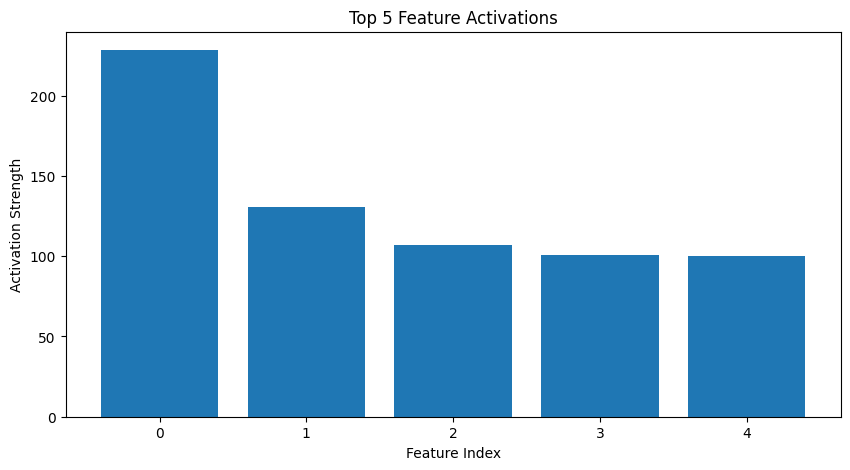

In [12]:
import torch
from PIL import Image
import torchvision.transforms as transforms

def get_clip_output(model, image_path, device='cuda'):
    # Preprocessing pipeline
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    try:
        # Load and process image
        image = Image.open(image_path).convert('RGB')
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        
        # Get model output
        with torch.no_grad():
            features = model.image_encoder(image_tensor)
            # Get top feature values
            top_values, _ = torch.topk(features.squeeze(), k=5)
            print("\nModel Output Features (Top 5):")
            print(top_values.cpu().numpy())
            
    except Exception as e:
        print(f"Error: {e}")

# Usage
image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"
get_clip_output(model, image_path)
# Add visualization to see which features are most activated
def visualize_features(features):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 5))
    plt.bar(range(5), features)
    plt.title('Top 5 Feature Activations')
    plt.xlabel('Feature Index')
    plt.ylabel('Activation Strength')
    plt.show()

# Usage
# visualize_features([228.35013, 130.38225, 106.90538, 100.50372, 100.14967])

In [15]:
import os
from collections import Counter
from transformers import BertTokenizer
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms

def extract_vocabulary(reports_folder):
    """Extract vocabulary from medical reports"""
    vocab = Counter()
    for filename in os.listdir(reports_folder):
        if filename.endswith('.txt'):
            with open(os.path.join(reports_folder, filename), 'r') as f:
                text = f.read().lower()
                # Split into words and count
                words = text.split()
                vocab.update(words)
    
    # Filter common medical terms (frequency > 5)
    medical_vocab = [word for word, count in vocab.items() if count > 5]
    return medical_vocab

def match_image_to_vocab(model, image_path, vocab, device='cuda'):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Process image
    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    
    # Process vocabulary
    text_inputs = tokenizer(vocab, padding=True, truncation=True, return_tensors="pt")
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
    
    with torch.no_grad():
        img_features, text_features = model(
            image_tensor,
            text_inputs['input_ids'],
            text_inputs['attention_mask']
        )
        
        # Calculate similarities
        similarities = F.cosine_similarity(
            img_features.unsqueeze(1),
            text_features.unsqueeze(0),
            dim=-1
        )
        
        # Get top matches
        top_scores, top_indices = similarities[0].topk(10)
        
        print("\nTop matching terms from reports:")
        for score, idx in zip(top_scores, top_indices):
            print(f"- {vocab[idx]}: {score:.3f}")

# Usage
reports_folder = "path/to/reports/folder"
vocab = extract_vocabulary(reports_folder)
image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"
match_image_to_vocab(model, image_path, vocab)


Top matching words:
- nodule: -0.062
- malignant: -0.076
- round: -0.078
- spiculated: -0.104
- scattered: -0.109

Top matching features:
- focal asymmetry: 1.000
- benign finding: 0.964
- suspicious mass: 0.763
- fibroglandular tissue: 0.557
- architectural distortion: 0.544


In [22]:
import os
from collections import Counter
from transformers import BertTokenizer
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms

def extract_vocabulary(reports_folder):
    """Extract vocabulary from medical reports"""
    vocab = Counter()
    for filename in os.listdir(reports_folder):
        if filename.endswith('.txt'):
            with open(os.path.join(reports_folder, filename), 'r') as f:
                text = f.read().lower()
                # Split into words and count
                words = text.split()
                vocab.update(words)
    
    # Filter common medical terms (frequency > 5)
    medical_vocab = [word for word, count in vocab.items() if count > 5]
    return medical_vocab

def match_image_to_terms_normalized(model, image_path, vocab, device='cuda'):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    temperature = 0.07  # Temperature scaling factor
    
    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        
        text_inputs = tokenizer(vocab, padding=True, truncation=True, return_tensors="pt")
        text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
        
        with torch.no_grad():
            img_features, text_features = model(
                image_tensor,
                text_inputs['input_ids'],
                text_inputs['attention_mask']
            )
            
            # Ensure L2 normalization
            img_features = F.normalize(img_features, dim=-1)
            text_features = F.normalize(text_features, dim=-1)
            
            # Calculate similarity with temperature scaling
            similarities = torch.mm(img_features, text_features.t()) / temperature
            
            # Convert to probabilities
            probs = F.softmax(similarities, dim=-1)
            
            # Get absolute values and normalize to [0,1]
            scores = torch.abs(similarities[0])
            scores = (scores - scores.min()) / (scores.max() - scores.min())
            
            top_scores, top_indices = scores.topk(10)
            
            print("\nTop matching terms (normalized):")
            for score, idx in zip(top_scores, top_indices):
                print(f"- {vocab[idx]}: {score:.3f}")
                
    except Exception as e:
        print(f"Error: {e}")

# Usage
reports_folder = "D:\\DMID\\24522883\\Reports\\Reports"
vocab = extract_vocabulary(reports_folder)
image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"
match_image_to_vocab(model, image_path, vocab)
print(vocab)

c:\Users\Karim Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Top matching terms from reports:
- fibroadenoma: 0.081
- (acr: 0.025
- abnormality: 0.007
- findings:: -0.004
- may: -0.006
- 3).: -0.012
- 2).: -0.013
- lobulated: -0.016
- adenopathy: -0.028
- 2): -0.028
['breast', 'composition:', 'predominantly', 'fibro', 'fatty', 'parenchyma', '(acr', 'b)', 'birads:', '3', 'and', '5', 'findings:', 'irregular', 'ill-defined', 'soft', 'opacity', 'with', 'microcalcifications', 'suggests', 'malignant', 'lesion', 'small', 'well', 'defined', 'nodular', 'benign', '(birads-3)', 'vascular', 'calcifications', 'skin', 'nipple', '-', 'no', 'abnormality', 'axillary', 'adenopathy', 'scattered', 'glandular', '1', 'abnormal', 'looking', 'a)', 'well-defined', 'suggest', 'c)', 'oval', 'opacities', 'in', 'retroareolar', 'upper', 'quadrant', 'lesions', 'outer', '4b', 'spiculated', 'margin', 'the', 'suspicious', '4c', '4a', 'a', 'large', 'partially', 'seen', 'low', 'region', 'to', 'be', 'appears', 'benign-looking', 'adenopathy.', 'moderate', 'causing', 'architectural'

### Similarity Checking

In [3]:
import torch
from PIL import Image
from transformers import BertTokenizer
import torchvision.transforms as transforms

# Load the model
model = CLIPv02(embed_dim=1024)
checkpoint = torch.load("G:\\PYTHON\\open_clip\\models\\clip_v02_final-AugL-Drop-03.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\Karim Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Karim Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `

CLIPv02(
  (image_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [ ]:

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"
text = """
BREAST COMPOSITION: 
fibro fatty and glandular breast parenchyma (ACR C)

BIRADS: 3

FINDINGS: 
few overlapping lobulated soft opacities seen in the outer quadrant of the breast suggest probably benign lesions (BIRADS 3). 

skin and nipple appear normal. 

no abnormal microcalcification.


"""


image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)


inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
text_input_ids = inputs['input_ids'].to(device)
attn_mask = (text_input_ids > 0).to(device)

#  inference
with torch.no_grad():
    img_features, text_features = model(image, text_input_ids, attn_mask)

# similarity score
similarity_score = torch.matmul(img_features, text_features.T).item()
print(f"Similarity Score: {similarity_score*100}")
# Similarity Score: 94.13514137268066

c:\Users\Karim Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Similarity Score: 94.13514137268066


In [4]:
from torchvision.transforms import transforms
from transformers import BertTokenizer

model = CLIPv02(embed_dim=1024)
checkpoint = torch.load("G:\\PYTHON\\open_clip\\models\\clip_v02_final-AugL-Drop-03.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Image preprocessing
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Text tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
text = """
BREAST COMPOSITION: 
fibro fatty and glandular breast parenchyma (ACR C)

BIRADS: 3

FINDINGS: 
few overlapping lobulated soft opacities seen in the outer quadrant of the breast suggest probably benign lesions (BIRADS 3). 

skin and nipple appear normal. 

no abnormal microcalcification.


"""
tokenized_text = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

image = Image.open("D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg")
image = image_transform(image).unsqueeze(0).to(device)  # Add batch dimension
input_ids = tokenized_text['input_ids'].to(device)
attn_mask = tokenized_text['attention_mask'].to(device)


with torch.no_grad():
    img_features, text_features = model(image, input_ids, attn_mask)

similarity = torch.nn.functional.cosine_similarity(img_features, text_features)
print(f"Similarity: {similarity.item()*100}")


c:\Users\Karim Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Karim Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `

Similarity: -8.002786338329315


In [6]:
import os
from duckdb import checkpoint
import torch
from PIL import Image
import open_clip
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import string
import ollama

# Ensure you have the necessary NLTK data
nltk.download('stopwords')

# Load the fine-tuned CLIP model
# model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
# model.load_state_dict(torch.load("G:\\PYTHON\\open_clip\\fine_tuned_clip_dmid.pth"))
# model.eval()
model = CLIPv02(embed_dim=1024)
checkpoint = torch.load("G:\\PYTHON\\open_clip\\models\\clip_v02_final-AugL-Drop-03.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to read all reports from a folder
def read_reports(report_folder):
    reports = []
    for filename in os.listdir(report_folder):
        if filename.endswith(".txt"):
            with open(os.path.join(report_folder, filename), 'r') as file:
                reports.append(file.read())
    return reports

# Function to preprocess text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Function to extract important vocabulary using TF-IDF
def extract_vocabulary(reports):
    preprocessed_reports = [preprocess_text(report) for report in reports]
    vectorizer = TfidfVectorizer(max_features=100)  # Adjust max_features as needed
    X = vectorizer.fit_transform(preprocessed_reports)
    vocabulary = vectorizer.get_feature_names_out()
    return vocabulary

# Function to preprocess and encode images and texts
def extract_keywords(image_path, texts):
    # Preprocess the image
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    
    # Tokenize the texts
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    text_tokens = tokenizer(texts).to(device)
    
    # Encode the image and texts
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_tokens)
        
        # Normalize the features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # Compute similarity scores
        similarity = (image_features @ text_features.T).softmax(dim=-1)
    
    return similarity

# Function to generate a report using the Ollama model
def generate_report_ollama(keywords):
    input_text = """Generate a medical report: "Breast Composition, BIRADS, and Findings:". based on the following keywords: """ + ", ".join(keywords)
    
    messages = [
        {
            'role': 'user',
            'content': input_text
        }
    ]
    
    response = ollama.chat(model='gemma2:2b', messages=messages)
    report = response['message']['content']
    
    return report

# Example usage
report_folder = "D:\\DMID\\24522883\\Reports\\Reports"  # Replace with your reports folder path
image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"  # Replace with your image path

# Read and preprocess reports
reports = read_reports(report_folder)
vocabulary = extract_vocabulary(reports)

# Extract the most relevant keywords
similarity_scores = extract_keywords(image_path, vocabulary)
best_match_indices = similarity_scores.argsort(descending=True).squeeze().tolist()
top_keywords = [vocabulary[i] for i in best_match_indices[:20]]
print(top_keywords)  # Select top 10 keywords

# Generate the report based on the top keywords
generated_report = generate_report_ollama(top_keywords)
print("\nGenerated Report:")
print(generated_report)
#['nipple', 'breast', 'fatty', 'abnormal', 'soft', 'oval', 'mild', 'skin', 'normal', 'abnormality']

[nltk_data] Downloading package stopwords to C:\Users\Karim
[nltk_data]     Mohamed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will 

NameError: name 'preprocess' is not defined

In [18]:
import os
import torch
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import string
import ollama
from transformers import BertTokenizer
import torchvision.transforms as transforms

# Ensure you have the necessary NLTK data
nltk.download('stopwords')

# Initialize model and load checkpoint
model = CLIPv02(embed_dim=1024)
checkpoint = torch.load("G:\\PYTHON\\open_clip\\models\\clip_v02_final-AugL-Drop-03.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize tokenizer and preprocessing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

def read_reports(report_folder):
    reports = []
    for filename in os.listdir(report_folder):
        if filename.endswith(".txt"):
            with open(os.path.join(report_folder, filename), 'r') as file:
                reports.append(file.read())
    return reports

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

def extract_vocabulary(reports):
    preprocessed_reports = [preprocess_text(report) for report in reports]
    vectorizer = TfidfVectorizer(max_features=100)
    X = vectorizer.fit_transform(preprocessed_reports)
    vocabulary = vectorizer.get_feature_names_out()
    return vocabulary

# Function to extract keywords using correct model methods
def extract_keywords(image_path, texts):
    # Ensure texts is list
    if not isinstance(texts, list):
        texts = texts.tolist()
    
    # Preprocess image
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    
    # Process texts in batches
    all_text_features = []
    batch_size = 32
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        # Tokenize
        text_tokens = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)
        
        # Get text embeddings using forward pass
        with torch.no_grad():
            # Use forward pass instead of encode_text
            text_output = model.text_encoder(text_tokens.input_ids)[1]  # Get pooled output
            text_features = model.text_proj(text_output)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            all_text_features.append(text_features)
    
    # Stack text features
    text_features = torch.cat(all_text_features, dim=0)
    
    # Get image features using forward pass
    with torch.no_grad():
        # Use forward pass instead of encode_image
        image_output = model.image_encoder(image)
        image_features = model.image_proj(image_output)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        # Compute similarity
        similarity = (image_features @ text_features.T).softmax(dim=-1)
    
    return similarity

def generate_report_ollama(keywords):
    input_text = """Generate a medical report: "Breast Composition, BIRADS, and Findings:". based on the following keywords: """ + ", ".join(keywords)
    messages = [{'role': 'user', 'content': input_text}]
    response = ollama.chat(model='gemma2:2b', messages=messages)
    return response['message']['content']

# Example usage
report_folder = "D:\\DMID\\24522883\\Reports\\Reports"
image_path = "D:\\DMID\\24522883\\DICOM Export\\img-00310-00001.jpg"

# Process reports and extract keywords
reports = read_reports(report_folder)
vocabulary = extract_vocabulary(reports)

# Get keywords
similarity_scores = extract_keywords(image_path, vocabulary)
best_match_indices = similarity_scores.argsort(descending=True).squeeze().tolist()
top_keywords = [vocabulary[i] for i in best_match_indices[:20]]
print("Top Keywords:", top_keywords)

# Generate report
# generated_report = generate_report_ollama(top_keywords)
# print("\nGenerated Report:")
# print(generated_report)

[nltk_data] Downloading package stopwords to C:\Users\Karim
[nltk_data]     Mohamed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will 

Top Keywords: ['microcalcifications', 'calcifications', 'abnormality', 'opacity', 'retraction', 'spiculated', 'axillary', 'parenchyma', 'periareolar', 'glandular', 'lesion', 'adenopathy', 'microcalcification', 'foci', 'opacities', 'calcification', 'benignlooking', 'birads3', 'birads', 'pectoral']
